This lab on Decision Trees in R is an abbreviated version of p. 324-331 of "Introduction to Statistical Learning with
Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

# 8.3.1 Fitting Classification Trees

The `tree` library is useful for constructing classification and regression trees:

In [20]:
list.of.packages <- c("dplyr","gbm","ggplot2","ISLR","MASS","randomForest","tree","caret","e1071")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)


Installing package into ‘/home/iserina/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


In [21]:
library(tree)
library(ISLR)
library(dplyr)
library(ggplot2)
library(caret)
library(e1071)

We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise:

In [3]:
Carseats = Carseats %>%
  mutate(High = as.factor(ifelse(Sales <= 8, "No", "Yes")))

In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [4]:
set.seed(1)

train = Carseats %>%
  sample_n(200)

test = Carseats %>%
  setdiff(train)

We now use the `tree()` function to fit a classification tree in order to predict
`High` using all variables but `Sales` (that would be a little silly...). The syntax of the `tree()` function is quite
similar to that of the `lm()` function:

In [5]:
tree_carseats = tree(High ~ . -Sales, train)

The `summary()` function lists the variables that are used as internal nodes (forming decision points)
in the tree, the number of terminal nodes, and the (training) error rate:

In [6]:
summary(tree_carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = train)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Age"         "CompPrice"   "Income"     
[6] "Advertising" "Education"   "US"          "Population" 
Number of terminal nodes:  20 
Residual mean deviance:  0.4777 = 85.98 / 180 
Misclassification error rate: 0.09 = 18 / 200 

We see that the training error rate 9%. For classification trees, the `deviance`
reported in the output of `summary()` is given by:

$$-2\sum_m\sum_k n_{mk}log\hat{p}_{mk}$$

where $n_{mk}$ is the number of observations in the $m^{th}$ terminal node that
belong to the $k^{th}$ class. A small `deviance` indicates a tree that provides
a good fit to the (training) data. The `residual \ mean \ deviance` reported is
simply the `deviance` divided by $n−|T_0|$.

One of the most attractive properties of trees is that they can be
graphically displayed. We use the `plot()` function to display the tree structure,
and the `text()` function to display the node labels. The argument
`pretty = 0` instructs `R` to include the category names for any qualitative predictors,
rather than simply displaying a letter for each category:

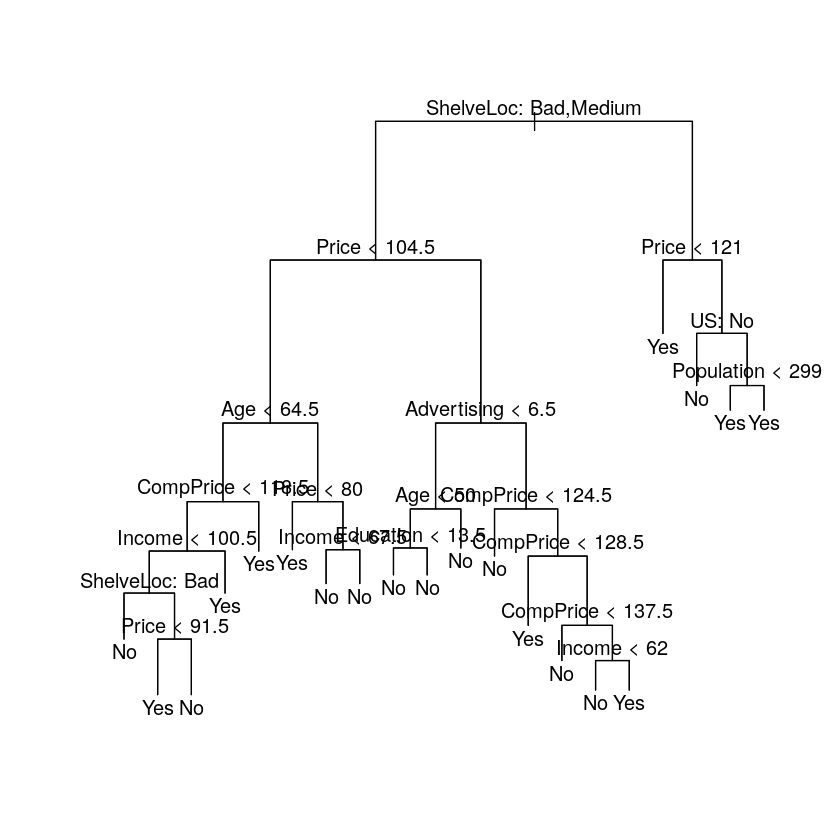

In [7]:
plot(tree_carseats)
text(tree_carseats, pretty = 0)

The most important indicator of `High` sales appears to be shelving location,
since the first branch differentiates `Good` locations from `Bad` and `Medium`
locations.

If we just type the name of the tree object, `R` prints output corresponding
to each branch of the tree. `R` displays the split criterion (e.g. $Price<142$), the
number of observations in that branch, the deviance, the overall prediction
for the branch (`Yes` or `No`), and the fraction of observations in that branch
that take on values of `Yes` and `No`. Branches that lead to terminal nodes are
indicated using asterisks:

In [8]:
tree_carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 200 269.200 No ( 0.60000 0.40000 )  
    2) ShelveLoc: Bad,Medium 164 206.400 No ( 0.67683 0.32317 )  
      4) Price < 104.5 65  89.350 Yes ( 0.44615 0.55385 )  
        8) Age < 64.5 40  47.050 Yes ( 0.27500 0.72500 )  
         16) CompPrice < 118.5 23  31.490 Yes ( 0.43478 0.56522 )  
           32) Income < 100.5 18  24.730 No ( 0.55556 0.44444 )  
             64) ShelveLoc: Bad 5   0.000 No ( 1.00000 0.00000 ) *
             65) ShelveLoc: Medium 13  17.320 Yes ( 0.38462 0.61538 )  
              130) Price < 91.5 6   0.000 Yes ( 0.00000 1.00000 ) *
              131) Price > 91.5 7   8.376 No ( 0.71429 0.28571 ) *
           33) Income > 100.5 5   0.000 Yes ( 0.00000 1.00000 ) *
         17) CompPrice > 118.5 17   7.606 Yes ( 0.05882 0.94118 ) *
        9) Age > 64.5 25  29.650 No ( 0.72000 0.28000 )  
         18) Price < 80 5   5.004 Yes ( 0.20000 0.80000 ) *
         19) Price > 80 20  16.910 N

Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. In the
case of a classification tree, the argument `type="class"` instructs `R` to return
the actual class prediction. This approach leads to correct predictions for
around 77% of the test data set:

In [14]:
tree_pred = predict(tree_carseats, test, type = "class")
table(tree_pred, test$High)
# (98+56)/200 = 77%

         
tree_pred No Yes
      No  98  28
      Yes 18  56

Compute performace measures

In [22]:
result <- confusionMatrix(tree_pred, test$High)

# View confusion matrix overall
result 


Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  98  28
       Yes 18  56
                                          
               Accuracy : 0.77            
                 95% CI : (0.7054, 0.8264)
    No Information Rate : 0.58            
    P-Value [Acc > NIR] : 1.341e-08       
                                          
                  Kappa : 0.52            
                                          
 Mcnemar's Test P-Value : 0.1845          
                                          
            Sensitivity : 0.8448          
            Specificity : 0.6667          
         Pos Pred Value : 0.7778          
         Neg Pred Value : 0.7568          
             Prevalence : 0.5800          
         Detection Rate : 0.4900          
   Detection Prevalence : 0.6300          
      Balanced Accuracy : 0.7557          
                                          
       'Positive' Class : No              
                                 

# Pruning

Next, we consider whether **pruning** the tree might lead to improved
results. The function `cv.tree()` performs cross-validation in order to
determine the optimal level of tree complexity; cost complexity pruning
is used in order to select a sequence of trees for consideration. We use
the argument `FUN = prune.misclass` in order to indicate that we want the
**classification error rate** as our cost function to guide the cross-validation and pruning process,
rather than the default for the `cv.tree()` function, which is `deviance`. The
`cv.tree()` function reports the number of terminal nodes of each tree considered
(size) as well as the corresponding error rate and the value of the
cost-complexity parameter used ($k$, which corresponds to $\alpha$ in the equation we saw in lecture).

In [ ]:
set.seed(3)
cv_carseats = cv.tree(tree_carseats, FUN = prune.misclass)

Note that, despite the name, the `dev` field corresponds to the **cross-validation error
rate** in this instance. Let's plot the error
rate as a function of size:

In [ ]:
plot(cv_carseats$size, cv_carseats$dev, type = "b")

We see from this plot that the tree with 7 terminal nodes results in the lowest
cross-validation error rate, with 59 cross-validation errors. 

We now apply the `prune.misclass()` function in order to prune the tree to
obtain the nine-node tree by setting the parameter `best = 7`:

In [ ]:
prune_carseats = prune.misclass(tree_carseats, best = 7)
plot(prune_carseats)
text(prune_carseats, pretty = 0)

How well does this pruned tree perform on the test data set? Once again,
we can apply the `predict()` function top find out:

In [ ]:
tree_pred = predict(prune_carseats, test, type = "class")
table(tree_pred, test$High)

Now $\frac{(96+54)}{200} =$ 75% of the test observations are correctly classified, so 
the pruning process produced a more interpretable tree, but at a slight cost in classification accuracy.

# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. First, we create a
training set, and fit the tree to the training data using `medv` (median home value) as our response:

In [ ]:
library(MASS)
set.seed(1)
boston_train = Boston %>%
  sample_frac(.5)

boston_test = Boston %>%
  setdiff(boston_train)

tree_boston=tree(medv~., boston_train)

summary(tree_boston)

Notice that the output of `summary()` indicates that only three of the variables
have been used in constructing the tree_ In the context of a regression
tree, the `deviance` is simply the sum of squared errors for the tree_ Let's
plot the tree:

In [ ]:
plot(tree_boston)
text(tree_boston, pretty = 0)

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$46,380 for larger homes ($rm>=7.437$) in suburbs in which residents have high socioeconomic
status ($lstat<9.715$).

Now we use the `cv.tree()` function to see whether pruning the tree will
improve performance:

In [ ]:
cv_boston = cv.tree(tree_boston)
plot(cv_boston$size, cv_boston$dev, type = 'b')

The 7-node tree is selected by cross-validation. We can prune the tree using the
`prune.tree()` function as before:

In [ ]:
prune_boston = prune.tree(tree_boston, 
                          best = 7)
plot(prune_boston)
text(prune_boston, pretty = 0)

Now we'll use the pruned tree to make predictions on the test set:

In [ ]:
single_tree_estimate = predict(prune_boston, 
                               newdata = boston_train)

ggplot() + 
    geom_point(aes(x = boston_test$medv, y = single_tree_estimate)) +
    geom_abline()

mean((single_tree_estimate - boston_test$medv)^2)

In other words, the test set MSE associated with the regression tree is
154.4729. The square root of the MSE is therefore around 12.428, indicating
that this model leads to test predictions that are within around \$12,428 of
the true median home value for the suburb.
    
# 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `R` and the version of the `randomForest` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `randomForest()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [ ]:
library(randomForest)
set.seed(1)
bag_boston = randomForest(medv~., 
                          data = boston_train, 
                          mtry = 13, 
                          importance = TRUE)
bag_boston

The argument `mtry = 13` indicates that all 13 predictors should be considered
for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

In [ ]:
bagged_estimate = predict(bag_boston, 
                          newdata = boston_test)

ggplot() + 
    geom_point(aes(x = boston_test$medv, y = bagged_estimate)) +
    geom_abline()

The test set MSE associated with the bagged regression tree is dramatically smaller than that obtained using an optimally-pruned single tree! We can change
the number of trees grown by `randomForest()` using the `ntree` argument:

In [ ]:
bag_boston_25_trees = randomForest(medv~., data =  boston_train, mtry = 13, ntree = 25)
bagged_estimate_25_trees = predict(bag_boston_25_trees, newdata = boston_test)
mean((bagged_estimate_25_trees - boston_test$medv)^2)

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `mtry` argument. By default, `randomForest()`
uses $p/3$ variables when building a random forest of regression trees, and
$\sqrt{p` variables when building a random forest of classification trees. Here we'll
use `mtry = 6`:

In [ ]:
set.seed(1)
rf_boston = randomForest(medv~., 
                         data = boston_train, 
                         mtry = 6, 
                         importance = TRUE)

random_forest_estimate = predict(rf_boston, 
                                 newdata = boston_test)

mean((random_forest_estimate - boston_test$medv)^2)

The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `importance()` function, we can view the importance of each
variable:

In [ ]:
importance(rf_boston)

Two measures of variable importance are reported. The former is based
upon the **mean decrease of accuracy in predictions** on the out-of-bag samples
when a given variable is excluded from the model. The latter is a measure
of the **total decrease in node impurity** that results from splits over that
variable, averaged over all tree_ In the
case of regression trees, the node impurity is measured by the training
RSS, and for classification trees by the deviance. Plots of these importance
measures can be produced using the `varImpPlot()` function:

In [ ]:
varImpPlot(rf_boston)

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

# 8.3.4 Boosting

Now we'll use the `gbm` package, and within it the `gbm()` function, to fit **boosted
regression trees** to the `Boston` data set. We run `gbm()` with the option
`distribution="gaussian"` since this is a regression problem; if it were a binary
classification problem, we would use `distribution="bernoulli"`. The
argument `n.trees=5000` indicates that we want 5000 trees, and the option
`interaction.depth=4` limits the depth of each tree:

In [ ]:
library(gbm)
set.seed(1)
boost_boston = gbm(medv~., 
                   data = boston_train, 
                   distribution = "gaussian", 
                   n.trees = 5000, 
                   interaction.depth = 4)

The `summary()` function produces a relative influence plot and also outputs
the relative influence statistics:

In [ ]:
summary(boost_boston)

We see that `lstat` and `rm` are again the most important variables by far. We can
also produce partial dependence plots for these two variables. These plots
illustrate the marginal effect of the selected variables on the response after
integrating out the other variables. In this case, as we might expect, median
house prices are increasing with `rm` and decreasing with `lstat`:

In [ ]:
par(mfrow = c(1,2))
plot(boost_boston, i = "rm")
plot(boost_boston, i = "lstat")

Now let's use the boosted model to predict `medv` on the test set:

In [ ]:
boost_estimate = predict(boost_boston, 
                         newdata = boston_test, 
                         n.trees = 5000)

mean((boost_estimate - boston_test$medv)^2)

The test MSE obtained is similar to the test MSE for random forests
and bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. The default
value is 0.001, but this is easily modified. Here we take $\lambda = 0.1$:

In [23]:
boost_boston2 = gbm(medv~., data = boston_train, 
                    distribution = "gaussian", 
                    n.trees = 5000, 
                    interaction.depth = 4, 
                    shrinkage = 0.01, 
                    verbose = F)

boost_estimate2 = predict(boost_boston2, newdata = boston_test, n.trees = 5000)
mean((boost_estimate2-boston_test$medv)^2)

ERROR: Error in gbm(medv ~ ., data = boston_train, distribution = "gaussian", : non trovo la funzione "gbm"


In this case, using $\lambda = 0.1$ leads to a slightly lower test MSE than $\lambda = 0.001$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671